In [1]:
library(tidyverse)
library(emdbook)
library(ramify)
library(gridExtra)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.0     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.1     ✔ tibble    3.2.0
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘ramify’


The following object is masked from ‘package:purrr’:

    flatten


The following object is masked from ‘package:tidyr’:

    fill


The following object is masked from ‘package:graphics’:

    clip



Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Exercise 1
• study the binomial inference for a study that reports y = 7 successes in n = 20 independent trial.
Assume the following priors:
- a uniform distribution
- a Jeffrey’s prior
- a step function:

In [2]:
n_succ = 7
n_trial = 20
p = seq(0,1, by= 0.01)

#Priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}

priorJ = function(p){g<-dbeta(p,0.5, 0.5)
                     return (g)}
priorC = function(p){
    g <- ifelse(p <= 0.2, p,
              ifelse(p > 0.2 & p <= 0.3, 0.2,
                    ifelse(p>0.3 & p <= 0.5, 0.5-p,0))) 
    return (g)
}



#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}



#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normJ = integrate(function(x){lhB(x)*priorJ(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value



#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postJ = function(p){i <- lhB(p)*priorJ(p)/normJ
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}
pU = postU(p)
pJ = postJ(p)
pC = postC(p)

pU[is.nan(pU)] = 0
pJ[is.nan(pJ)] = 0
pC[is.nan(pC)] = 0

• plot the posterior distribution and summerize the results computing the first two moments

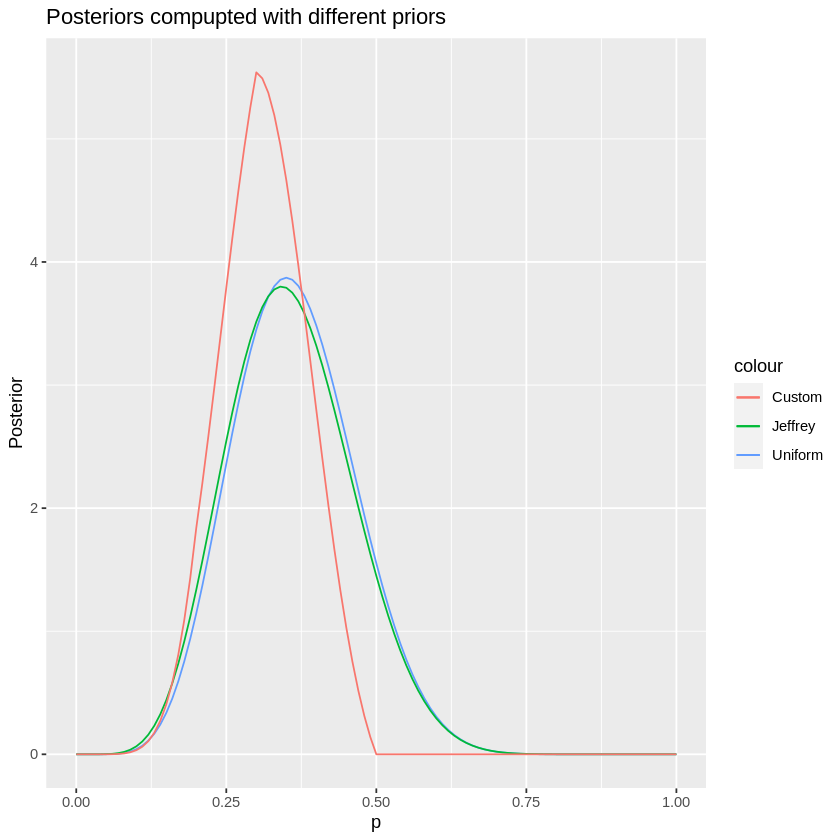

In [3]:
ggplot(data=data.frame(p, pU, pJ, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
                                                geom_line(aes(y=pJ, color='Jeffrey'))+
                                                geom_line(aes(y=pC, color='Custom'))+
                                                labs(title='Posteriors compupted with different priors',
                                                      x='p',
                                                      y='Posterior')

In [4]:
moment1U = integrate(function(x){x*postU(x)}, lower=0, upper=1)$value 
moment1J = integrate(function(x){x*postJ(x)}, lower=0, upper=1)$value 
moment1C = integrate(function(x){x*postC(x)}, lower=0, upper=1)$value 

moment2U = integrate(function(x){(moment1U - x)*(moment1U - x)*postU(x)}, lower=0, upper=1)$value 
moment2J = integrate(function(x){(moment1J - x)*(moment1J - x)*postJ(x)}, lower=0, upper=1)$value
moment2C = integrate(function(x){(moment1C - x)*(moment1C - x)*postC(x)}, lower=0, upper=1)$value

cat('The first and second moment using a uniform prior is: \t', moment1U, ' , ', moment2U, '\n')
cat('The first and second moment using a Jeffrey prior is: \t', moment1J, ' , ', moment2J, '\n')
cat('The first and second moment using a custom prior is: \t', moment1C, ' , ', moment2C, '\n')

The first and second moment using a uniform prior is: 	 0.3636364  ,  0.01006109 
The first and second moment using a Jeffrey prior is: 	 0.3571429  ,  0.01043599 
The first and second moment using a custom prior is: 	 0.3120452  ,  0.004998428 


• compute a 95% credibility interval and give the results in a summary table

In [5]:
xU = ncredint(pvec=p, npost=pU,level=0.95,tol=0.01,verbose=FALSE)
xJ = ncredint(pvec=p, npost=pJ,level=0.95,tol=0.01,verbose=FALSE)
xC = ncredint(pvec=p, npost=pC,level=0.95,tol=0.01,verbose=FALSE)


uniform = c(moment1U, moment2U, xU[['lower']], xU[['upper']])
jeffrey = c(moment1J, moment2J, xJ[['lower']], xJ[['upper']])
custom = c(moment1C, moment2C, xC[['lower']], xC[['upper']])



df = data.frame(Uniform = uniform, Jeffrey = jeffrey, Custom=custom,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

Uniform    Jeffrey    Custom     
First moment                  0.36363636 0.35714286 0.312045223
Second moment                 0.01006109 0.01043599 0.004998428
Lower limit (95% credibility) 0.18000000 0.17000000 0.180000000
Upper limit (95% credibility) 0.56000000 0.55000000 0.440000000

• draw the limits on the plot of the posterior distribution

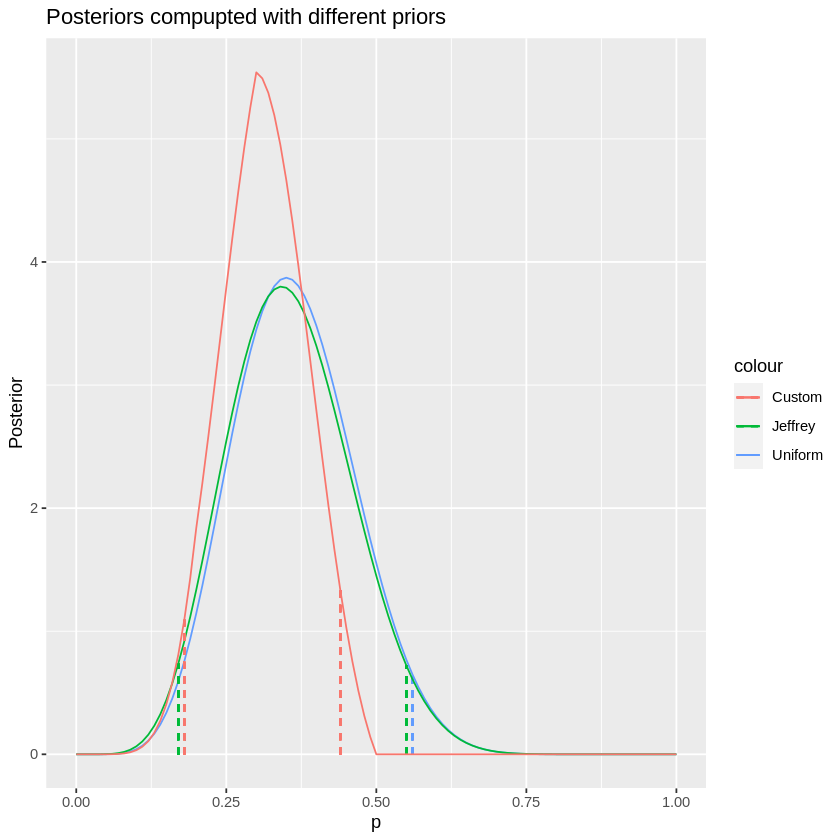

In [6]:
ggplot(data=data.frame(p, pU, pJ, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
geom_segment(aes(x = xU[['lower']] , y = 0, xend = xU[['lower']], yend = postU(xU[['lower']]), color='Uniform'),linetype='dashed')+
geom_segment(aes(x = xU[['upper']] , y = 0, xend = xU[['upper']], yend = postU(xU[['upper']]), color='Uniform'),linetype='dashed')+
geom_line(aes(y=pJ, color='Jeffrey'))+
geom_segment(aes(x = xJ[['lower']] , y = 0, xend = xJ[['lower']], yend = postJ(xJ[['lower']]), color='Jeffrey'),linetype='dashed')+
geom_segment(aes(x = xJ[['upper']] , y = 0, xend = xJ[['upper']], yend = postJ(xJ[['upper']]), color='Jeffrey'),linetype='dashed')+
geom_line(aes(y=pC, color='Custom'))+
geom_segment(aes(x = xC[['lower']] , y = 0, xend = xC[['lower']], yend = postC(xC[['lower']]), color='Custom'),linetype='dashed')+
geom_segment(aes(x = xC[['upper']] , y = 0, xend = xC[['upper']], yend = postC(xC[['upper']]), color='Custom'),linetype='dashed')+
labs(title='Posteriors compupted with different priors',x='p',y='Posterior')                                               

# Exercise 2

• Giardia cysts[1] is a parassite that can contaminate food, water, and surfaces, and they can cause
giardiasis when swallowed in this infective stage of their life cycle. Infection occurs when a person
swallows Giardia cysts from contaminated water, food, hands, surfaces, or objects.

• a group of researchers, working for a Human Health Department, work for determining the quality
of stream water

• they take n = 116 samples of one-liter water from sites identified to have a heavy environmental
impact from birds and waterflow.

• out of these samples, y = 17 samples contained Giard cystis

• assuming π as the probability that one-liter water sample contains Giardia cystis, find the posterior
distribution for π
- assuming a uniform prior distribution
- assuming a Beta (1, 4) prior

In [7]:
n_succ = 17
n_trial = 116
p = seq(0,1, by= 0.005)

#priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}

priorC = function(p){g<-dbeta(p,1, 4)
                     return (g)}

#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}

#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value


#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}

pU = postU(p)
pC = postC(p)

pU[is.nan(pU)] = 0
pC[is.nan(pC)] = 0

• plot the posterior distribution and summerize the results computing the first two moments

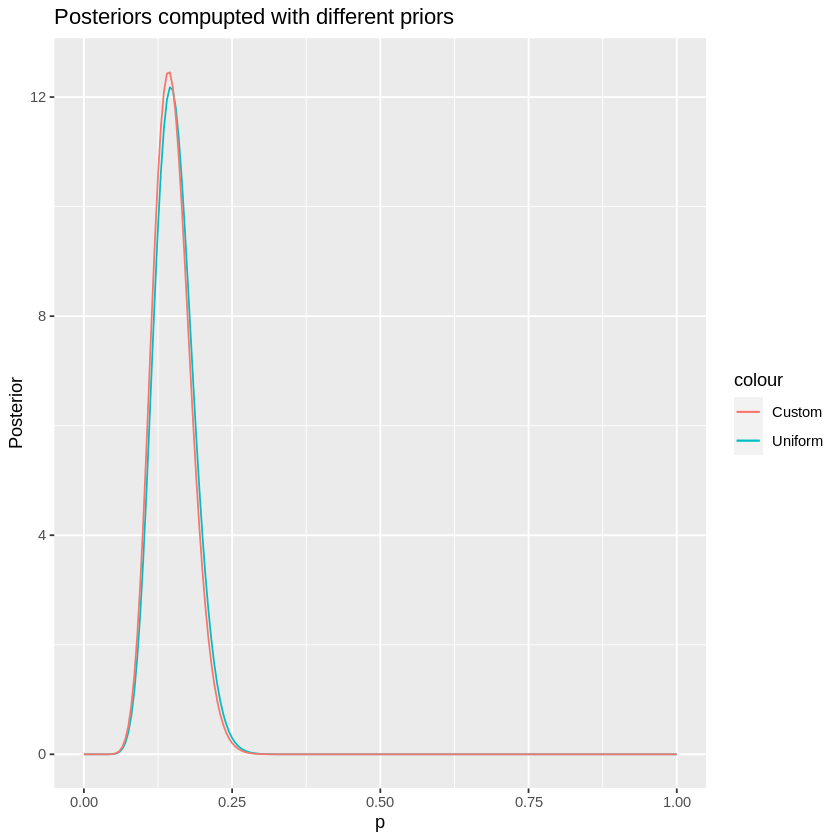

In [8]:
ggplot(data=data.frame(p, pU, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
                                geom_line(aes(y=pC, color='Custom'))+
                                labs(title='Posteriors compupted with different priors',
                                     x='p',
                                     y='Posterior')

In [9]:
moment1U = integrate(function(x){x*postU(x)}, lower=0, upper=1)$value 
moment1C = integrate(function(x){x*postC(x)}, lower=0, upper=1)$value 

moment2U = integrate(function(x){(x-moment1U)*(x-moment1U)*postU(x)}, lower=0, upper=1)$value 
moment2C = integrate(function(x){(x-moment1C)*(x-moment1C)*postC(x)}, lower=0, upper=1)$value

cat('The first and second moment using a uniform prior is: \t', moment1U, ' , ', moment2U, '\n')
cat('The first and second moment using a custom prior is: \t', moment1C, ' , ', moment2C, '\n')

The first and second moment using a uniform prior is: 	 0.1525424  ,  0.001086329 
The first and second moment using a custom prior is: 	 0.1487603  ,  0.001037957 


• find a normal approximation for the posterior g (π ∣ y)

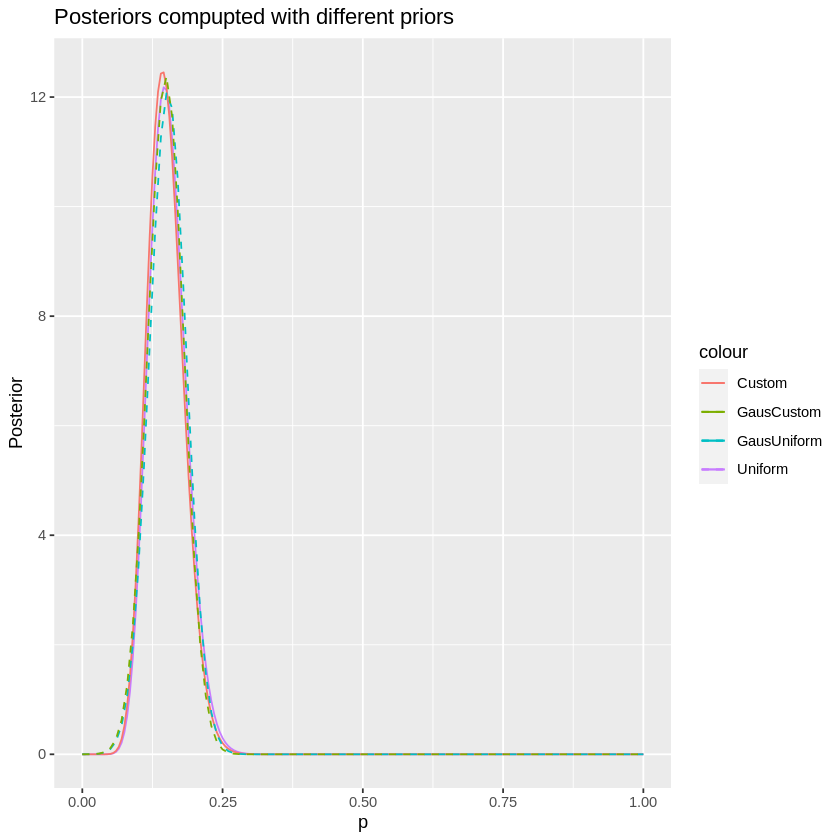

In [10]:
ggplot(data=data.frame(p, pU, pC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
                                geom_line(aes(y=pC, color='Custom'))+
                                labs(title='Posteriors compupted with different priors',
                                     x='p',
                                     y='Posterior')+                               
    geom_function(fun = dnorm, args = list(mean = moment1U, sd = sqrt(moment2U)), aes(color = "GausUniform"), linetype='dashed')+
    geom_function(fun = dnorm, args = list(mean = moment1C, sd = sqrt(moment2C)), aes(color = "GausCustom"), linetype='dashed')

• compute a 95% credibility interval both for the original posterior and for the normal approximation,
giving the results in a summary table

In [11]:
xU = ncredint(pvec=p, npost=pU,level=0.95,tol=0.01,verbose=FALSE)
xC = ncredint(pvec=p, npost=pC,level=0.95,tol=0.01,verbose=FALSE)

xnU = ncredint(pvec=p, npost=dnorm(p, mean=moment1U, sd=sqrt(moment2U)),level=0.95,tol=0.01,verbose=FALSE)
xnC = ncredint(pvec=p, npost=dnorm(p, mean=moment1C, sd=sqrt(moment2C)),level=0.95,tol=0.01,verbose=FALSE)


uniform = c(moment1U, moment2U, xU[['lower']], xU[['upper']])
custom = c(moment1C, moment2C, xC[['lower']], xC[['upper']])

gausU = c(moment1U, moment2U, xnU[['lower']], xnU[['upper']])
gausC = c(moment1C, moment2C, xnC[['lower']], xnC[['upper']])


df = data.frame(Uniform = uniform, GausUniform=gausU, Beta=custom, GausBeta=gausC,
          row.names=c('First moment', 'Second moment', 'Lower limit (95% credibility)', 'Upper limit (95% credibility)'))
df

Uniform     GausUniform Beta        GausBeta   
First moment                  0.152542373 0.152542373 0.148760331 0.148760331
Second moment                 0.001086329 0.001086329 0.001037957 0.001037957
Lower limit (95% credibility) 0.090000000 0.090000000 0.090000000 0.090000000
Upper limit (95% credibility) 0.215000000 0.215000000 0.210000000 0.210000000

In [12]:
dnorm(xnU[['lower']], mean=moment1U, sd=sqrt(moment2U))

[1] 2.000077

• add the limits on the plot of the posterior distributions

In [13]:
pnU = dnorm(p, mean=moment1U, sd=sqrt(moment2U))
pnC = dnorm(p, mean=moment1C, sd=sqrt(moment2C))

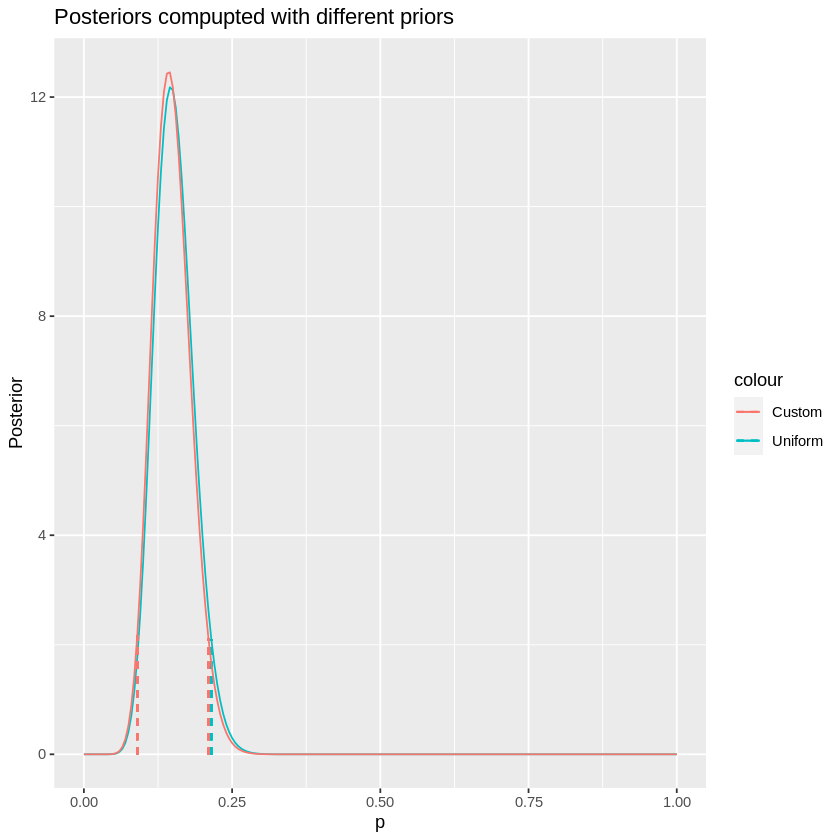

In [14]:
ggplot(data=data.frame(p, pU, pnU, pC, pnC), aes(x=p))+geom_line(aes(y=pU, color='Uniform'))+
geom_segment(aes(x = xU[['lower']] , y = 0, xend = xU[['lower']], yend = postU(xU[['lower']]), color='Uniform'),linetype='dashed')+
geom_segment(aes(x = xU[['upper']] , y = 0, xend = xU[['upper']], yend = postU(xU[['upper']]), color='Uniform'),linetype='dashed')+
# geom_line(aes(y=pnU, color='nUniform'))+
# geom_segment(aes(x = xnU[['lower']] , y = 0, xend = xnU[['lower']], yend = dnorm(xnU[['lower']], mean=moment1U, sd=sqrt(moment2U)), color='nUniform'),linetype='dashed')+
# geom_segment(aes(x = xnU[['upper']] , y = 0, xend = xnU[['upper']], yend = dnorm(xnU[['upper']], mean=moment1U, sd=sqrt(moment2U)), color='nUniform'),linetype='dashed')+
geom_line(aes(y=pC, color='Custom'))+
geom_segment(aes(x = xC[['lower']] , y = 0, xend = xC[['lower']], yend = postC(xC[['lower']]), color='Custom'),linetype='dashed')+
geom_segment(aes(x = xC[['upper']] , y = 0, xend = xC[['upper']], yend = postC(xC[['upper']]), color='Custom'),linetype='dashed')+
# geom_line(aes(y=pnC, color='nCustom'))+
# geom_segment(aes(x = xnC[['lower']] , y = 0, xend = xnC[['lower']], yend = dnorm(xnC[['lower']], mean=moment1C, sd=sqrt(moment2C)), color='nCustom'),linetype='dashed')+
# geom_segment(aes(x = xnC[['upper']] , y = 0, xend = xnC[['upper']], yend = dnorm(xnC[['upper']], mean=moment1C, sd=sqrt(moment2C)), color='nCustom'),linetype='dashed')+
labs(title='Posteriors compupted with different priors',x='p',y='Posterior')      

# Exercise 3

• A coin is flipped n = 30 times with the following outcomes:
T, T, T, T, T, H, T, T, H, H, T, T, H, H, H, T, H, T, H, T, H, H, T, H, T, H, T, H,
H, H

a) Assuming a flat prior, and a beta prior, plot the likelihood, prior and posterior distributions for the
data set

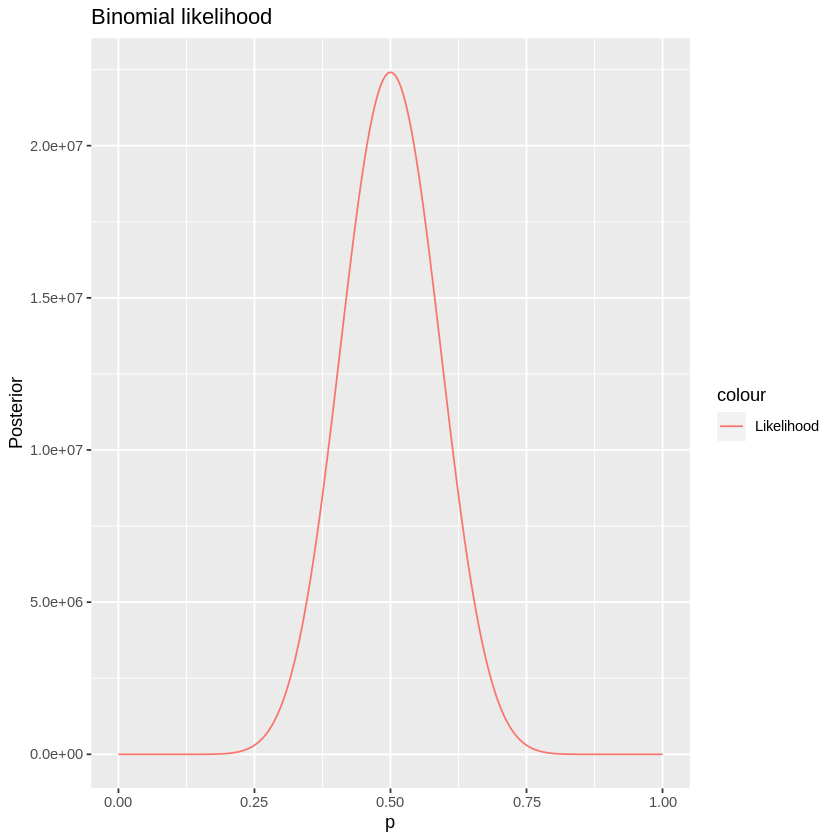

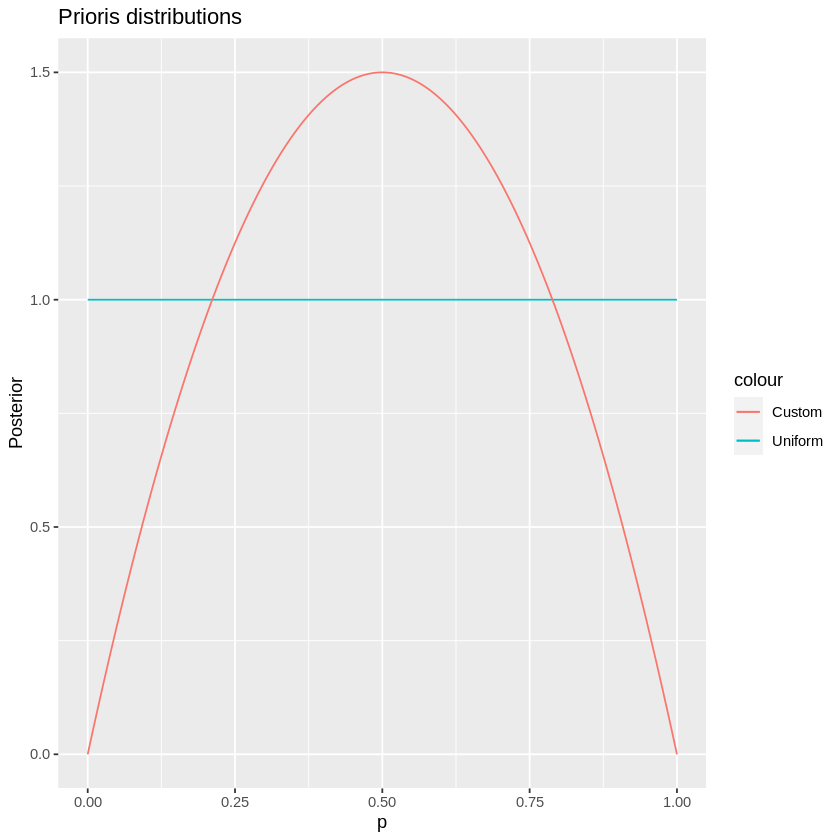

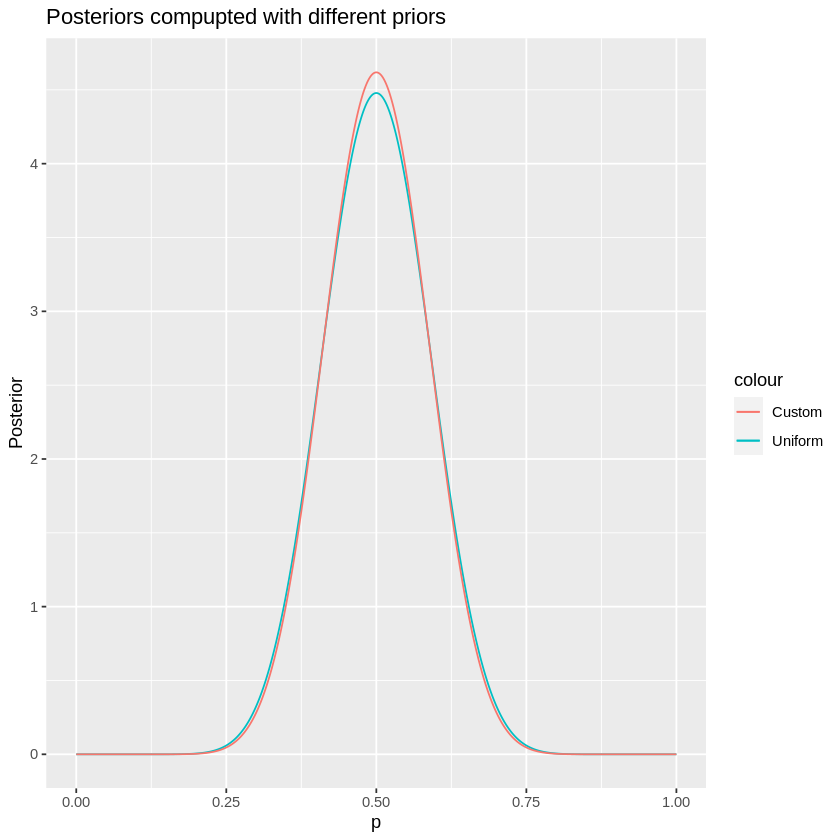

In [15]:
n_trial = 30
n_succ = 15
p = seq(0,1, by= 0.00005)
#priors
priorU = function(p){g<-dunif(p, 0, 1)
                     return (g)}
priorC = function(p){g<-dbeta(p,2, 2)
                     return (g)}

#likelihood
lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                 return (g)}

#normalisation terms
normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value


#posterior
postU = function(p){i <- lhB(p)*priorU(p)/normU
                   return (i)}
postC = function(p){i <- lhB(p)*priorC(p)/normC
                   return (i)}


prU = priorU(p)
prC = priorC(p)

lh = lhB(p)

pU = postU(p)
pC = postC(p)



pU[is.nan(pU)] = 0
pC[is.nan(pC)] = 0

ggplot(data=data.frame(p, lh), aes(x=p))+
geom_line(aes(y=lh, color='Likelihood'))+
labs(title='Binomial likelihood',x='p',y='Posterior')


ggplot(data=data.frame(p, prU, prC), aes(x=p))+
geom_line(aes(y=prU, color='Uniform'))+
geom_line(aes(y=prC, color='Custom'))+
labs(title='Prioris distributions',x='p',y='Posterior')

ggplot(data=data.frame(p, pU, pC), aes(x=p))+
geom_line(aes(y=pU, color='Uniform'))+
geom_line(aes(y=pC, color='Custom'))+
labs(title='Posteriors compupted with different priors',x='p',y='Posterior')

b) Evaluate the most probable value for the coin probability p and, integrating the posterior probability
distribution, give an estimate for a 95% credibility interval.

In [16]:
mpvU = which.max(pU)
mpvC = which.max(pC)
cat('The most probable value using a uniform prior is:', p[mpvU], '\n')
cat('The most probable value using a beta prior is:', p[mpvC], '\n')

xU = ncredint(pvec=p, npost=pU,level=0.95,tol=0.01,verbose=FALSE)
xC = ncredint(pvec=p, npost=pC,level=0.95,tol=0.01,verbose=FALSE)

cat(xU,'\n')
cat(xC,'\n')

The most probable value using a uniform prior is: 0.5 
The most probable value using a beta prior is: 0.5 
0.33065 0.66935 
0.3356 0.6644 


c) Repeat the same analysis assuming a sequential analysis of the data 1. Show how the most probable
value and the credibility interval change as a function of the number of coin tosses (i.e. from 1 to
30).

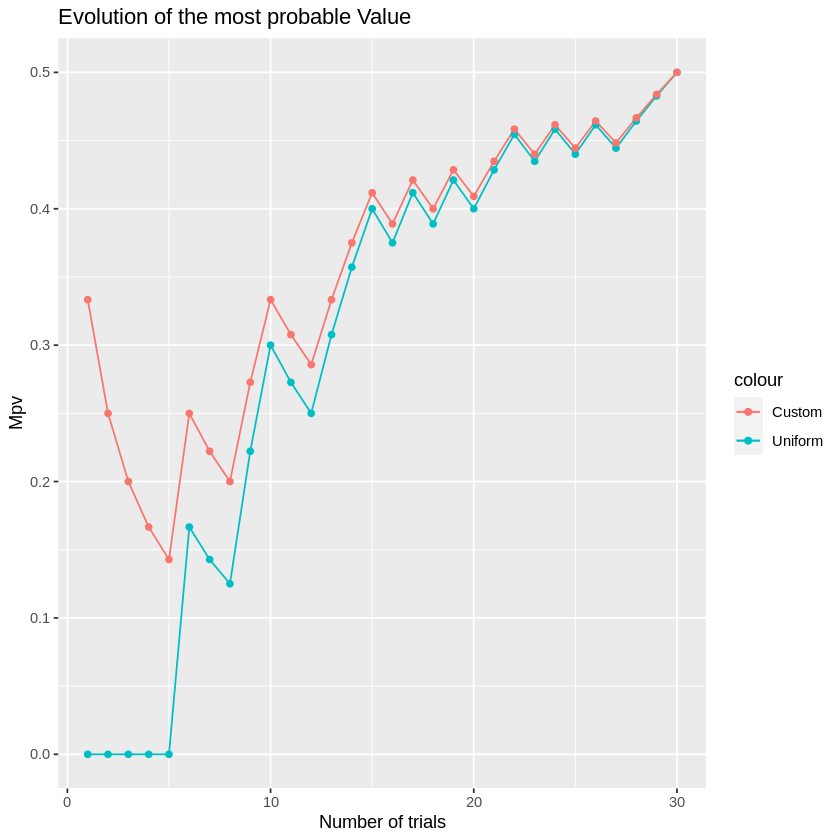

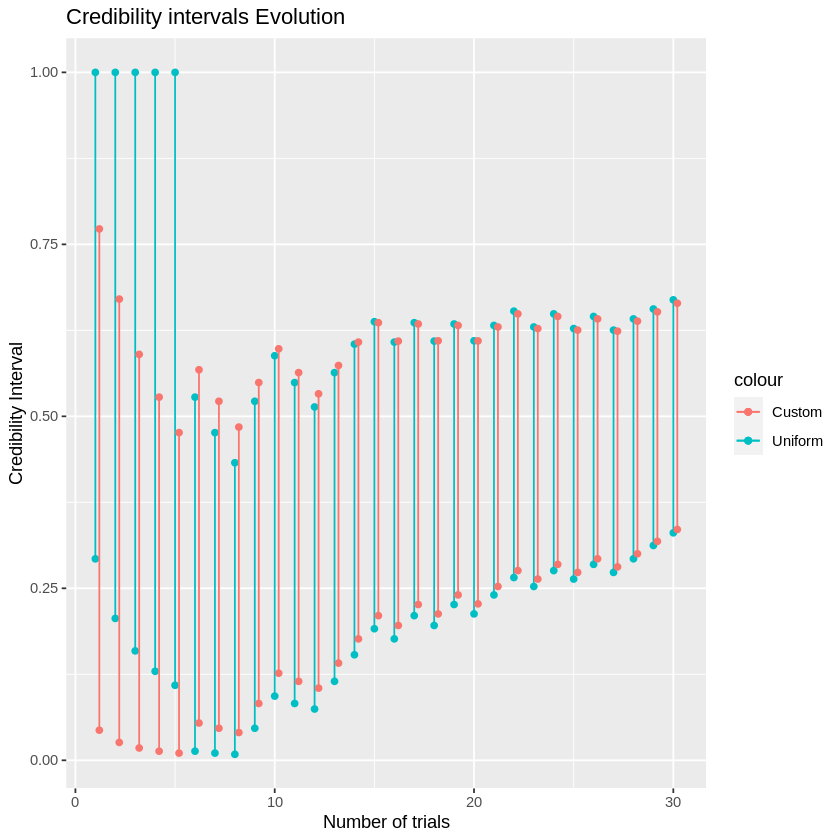

In [17]:
#head is good(1), tail is less good (0)
trial = c(0,0,0,0,0,1,0,0,1,1,0,0,1,1,1,0,1,0,1,0,1,1,0,1,0,1,0,1,1,1)

n_trial = 0
n_succ = 0
mpvU_ls = c()
mpvC_ls = c()

lwU_ls = c()
upU_ls = c()
lwC_ls = c()
upC_ls = c()


for (x in trial)
{
    n_trial=n_trial+1
    if(x==1){n_succ=n_succ+1}
    
    #priors
    priorU = function(p){g<-dunif(p, 0, 1)
                         return (g)}
    priorC = function(p){g<-dbeta(p,2, 2)
                         return (g)}

    #likelihood
    lhB = function(p){g <-dbinom(n_succ, n_trial, p)*choose(n_trial, n_succ)
                     return (g)}

    #normalisation terms
    normU = integrate(function(x){lhB(x)*priorU(x)}, lower=0, upper=1)$value
    normC = integrate(function(x){lhB(x)*priorC(x)}, lower=0, upper=1)$value


    #posterior
    postU = function(p){i <- lhB(p)*priorU(p)/normU
                       return (i)}
    postC = function(p){i <- lhB(p)*priorC(p)/normC
                       return (i)}

    pU = postU(p)
    pC = postC(p)

    pU[is.nan(pU)] = 0
    pC[is.nan(pC)] = 0
    
    mpvU = which.max(pU)
    mpvC = which.max(pC)
    
    mpvU_ls = c(mpvU_ls, p[mpvU])
    mpvC_ls = c(mpvC_ls, p[mpvC])
    
    xU = ncredint(pvec=p, npost=pU,level=0.95,tol=0.01,verbose=FALSE)
    xC = ncredint(pvec=p, npost=pC,level=0.95,tol=0.01,verbose=FALSE)
    
    lwU_ls = c(lwU_ls,xU[['lower']])
    upU_ls = c(upU_ls,xU[['upper']])
    
    lwC_ls = c(lwC_ls,xC[['lower']])
    upC_ls = c(upC_ls,xC[['upper']])
}

x = seq(1:30)
x1 = seq(from=1.2, to=30.2, by=1.)
ggplot(data=data.frame(x,mpvU_ls,mpvC_ls), aes(x=x))+
geom_line(aes(y=mpvU_ls, color='Uniform'))+
geom_line(aes(y=mpvC_ls, color='Custom'))+
geom_point(aes(y=mpvU_ls, color='Uniform'))+
geom_point(aes(y=mpvC_ls, color='Custom'))+
labs(title='Evolution of the most probable Value',x='Number of trials',y='Mpv')


ggplot()+
geom_segment(aes(x = x , y = lwU_ls, xend = x, yend = upU_ls, color='Uniform'))+
geom_point(aes(x = x, y = lwU_ls,color='Uniform'))+
geom_point(aes(x = x, y = upU_ls, color='Uniform'))+
geom_segment(aes(x = x1 , y = lwC_ls, xend = x1, yend = upC_ls, color='Custom'))+
geom_point(aes(x = x1 , y = lwC_ls, color='Custom'))+
geom_point(aes(x = x1, y = upC_ls, color='Custom'))+
labs(title='Credibility intervals Evolution',x='Number of trials',y='Credibility Interval')

d) Do you get a different result, by analyzing the data sequentially with respect to a one-step analysis
(i.e. considering all the data as a whole) ?

# Exercise 4 - Six Boxes Toy Model : inference

• write a program in R that performs a simulation of the process
1) after selecting a random box
2) make random sampling from the box
3) prins on the standard output the probability of selecting each box
4) plot the probability for each box as a function of the number of trial

Ramdomly choosen box: H_ 0

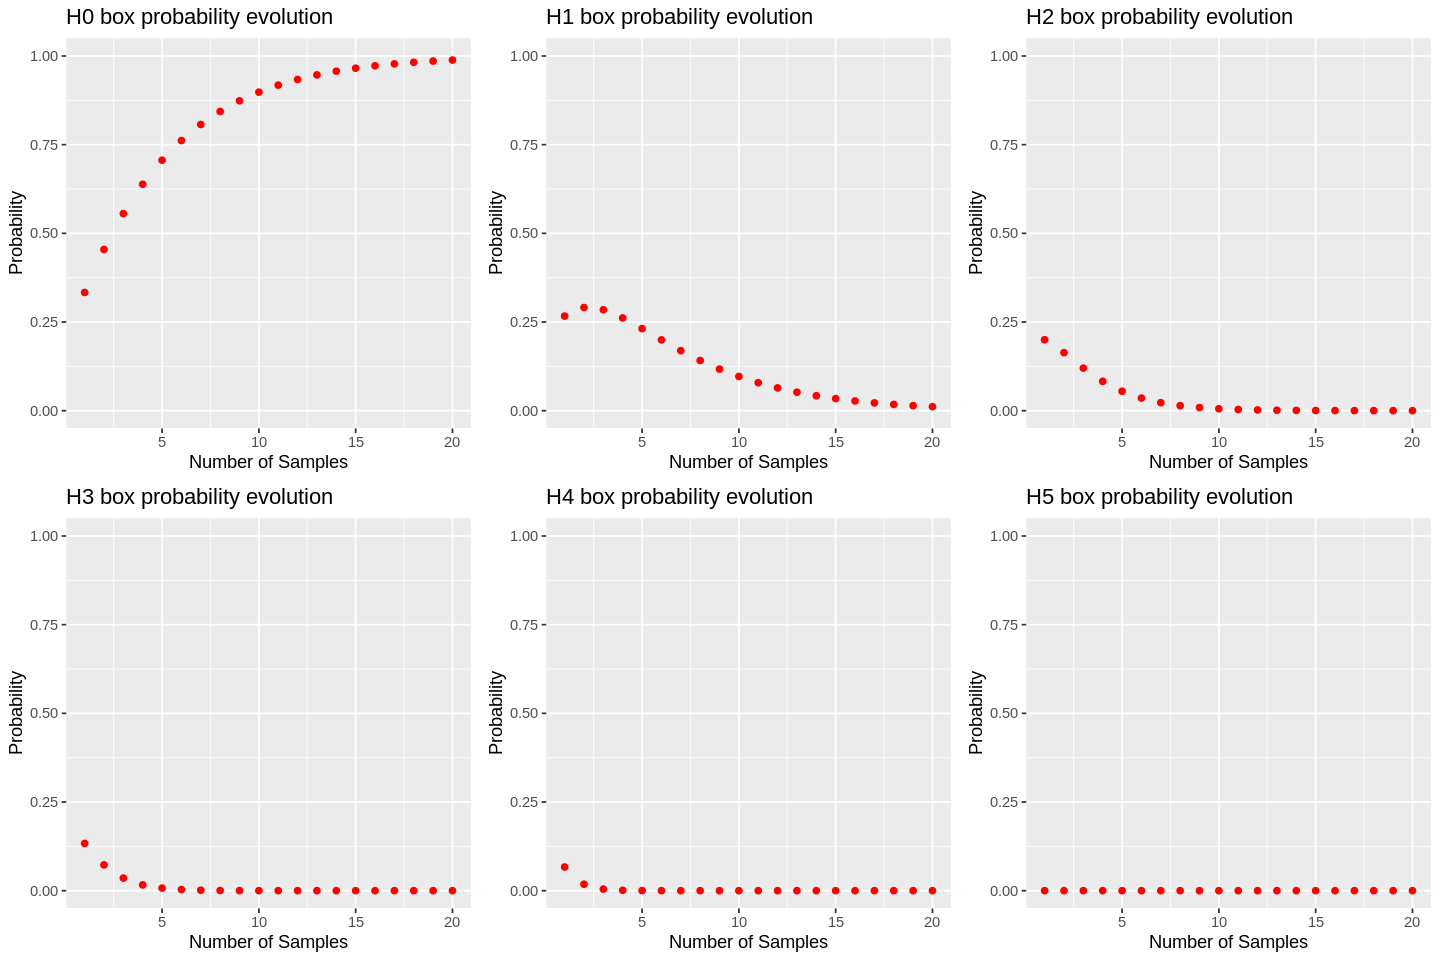

In [18]:
# 1 white
#0 black
j = sample(0:5, 1)
n_samples = 20
cat('Ramdomly choosen box: H_',j)

samp = function(j){
    if (runif(1) < j/5){res = 1}
    else{res=0}
    return(res)
}

pEH = function(sample, j){
    if (sample){return(j/5)}
    else{return((5-j)/5)}
}


pH = c(1/6, 1/6, 1/6, 1/6, 1/6, 1/6)


pH_0 = c()
pH_1 = c()
pH_2 = c()
pH_3 = c()
pH_4 = c()
pH_5 = c()

for (x in 1:n_samples){
    
    s = samp(j)
    
    
    pEH0 = c(pEH(s, 0), pEH(s, 1), pEH(s, 2), pEH(s, 3), pEH(s, 4), pEH(s, 5) )
    
    evidence = 0
    for (J in 1:6){
        evidence = evidence + pEH0[J]*pH[J]
    }
    
    for (J in 1:6){
        pH[J] =  pEH0[J]*pH[J]/evidence 
    }
    
    
    
    pH_0 = c(pH_0, pH[1])
    pH_1 = c(pH_1, pH[2])
    pH_2 = c(pH_2, pH[3])
    pH_3 = c(pH_3, pH[4])
    pH_4 = c(pH_4, pH[5])
    pH_5 = c(pH_5, pH[6])

}

p0 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_0), color='red') + labs(title='H0 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)
p1 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_1), color='red') + labs(title='H1 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)
p2 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_2), color='red') + labs(title='H2 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)
p3 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_3), color='red') + labs(title='H3 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)
p4 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_4), color='red') + labs(title='H4 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)
p5 = ggplot() + geom_point(aes(x=1:n_samples, y=pH_5), color='red') + labs(title='H5 box probability evolution', x='Number of Samples', y='Probability')+ylim(0,1)+xlim(1,n_samples)

options(repr.plot.width=12, repr.plot.height=8)
grid.arrange(p0, p1, p2, p3, p4, p5, ncol=3, nrow=2)
